In [1]:
import os
import numpy as np
import pandas as pd 
import glob
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# navigate to the project folder
os.chdir('C:/Users/jreyna/Documents/Projects/cmi-pb-multiomics/third_challenge')

# setting the output dir
outdir = 'results/main/2024.01.05/model_devel/'
os.makedirs(outdir, exist_ok=True)

In [2]:
model_dict = {'lr': LinearRegression, 
              'lasso': Lasso,
              'elastic_net': ElasticNet, 
              'lasso_cv': LassoCV,
              'elastic_net_cv': ElasticNetCV}

cmodel = 'lr'
cmodel = 'lasso'
#cmodel = 'elastic_net'
#cmodel = 'lasso_cv'
#cmodel = 'elastic_net_cv'
cmodel_function = model_dict[cmodel]

## Loading the loading matrices

In [3]:
loadings = {} 
tpl = "results/main/2024.01.05/cmi_pb_datasets/computable-matrices/training_dataset/*.jive-loadings.tsv"
for loading_fn in glob.glob(tpl):
    
    bn = os.path.basename(loading_fn)
    assay = bn.split('.')[0]
    loadings_matrix = pd.read_table(loading_fn)
    loadings[assay] = loadings_matrix

## Loading the input data

In [4]:
# setting up dictionaries to load data and results
features = {}
outcomes = {}

#### Extracting Features (calculating the reduced form of each omic)

In [5]:
with open('results/main/2024.01.05/cmi_pb_datasets/computable-matrices/training_dataset/common_samples.txt', 'r') as f:
    common_samples = [int(x.strip()) for x in f.readlines()]

In [6]:
tpl = 'results/main/2024.01.05/cmi_pb_datasets/computable-matrices/training_dataset/*.training-data.tsv'
for raw_fn in glob.glob(tpl):  
    
    bn = os.path.basename(raw_fn)
    assay = bn.split('.')[0]
    
    # Loading the raw matrices
    raw = pd.read_table(raw_fn, index_col=0, header=0)
    shared_columns = loadings[assay].index.tolist()
    raw = raw.loc[common_samples, shared_columns]
    raw_array = np.matrix(raw.values)
    
    ## Calculating the sample factor matrix
    loadings_array = np.matrix(loadings[assay].values)
    sample_factors = raw_array * loadings_array

    tdf = pd.DataFrame(sample_factors) 
    tdf.columns = ['{}-{}'.format(assay, i) for i in range(sample_factors.shape[1])]
    features[assay] = tdf
    features[assay].index = raw.index.tolist()

In [7]:
features['final'] = pd.concat([features['pbmc_cell_frequency'],
                                     features['plasma_cytokine_concentrations'],
                                     features['pbmc_gene_expression'],
                                     features['abtiter']], axis=1)

In [8]:
features['final'].head()

,pbmc_cell_frequency-0,pbmc_cell_frequency-1,pbmc_cell_frequency-2,pbmc_cell_frequency-3,pbmc_cell_frequency-4,pbmc_cell_frequency-5,pbmc_cell_frequency-6,pbmc_cell_frequency-7,pbmc_cell_frequency-8,pbmc_cell_frequency-9,...,abtiter-0,abtiter-1,abtiter-2,abtiter-3,abtiter-4,abtiter-5,abtiter-6,abtiter-7,abtiter-8,abtiter-9
33,-1.110421,-0.729115,-0.194013,-0.446445,0.009701,-0.862355,0.244240,0.287330,0.449174,-0.158775,...,-1.325683,-0.518658,0.306074,0.626647,0.884455,-1.437087,0.122978,-0.195141,0.033063,-1.223243
31,-0.326774,-1.209752,-0.292750,-0.940395,0.754149,-0.348609,-0.226301,0.120276,0.974449,0.811056,...,-1.316169,0.748127,0.081814,-0.443173,0.892538,-0.642241,1.059783,-0.461686,-0.485423,-0.202407
4,0.244100,0.238141,0.196914,-0.200498,-0.276279,0.018229,-0.138186,0.099384,0.053592,0.042884,...,1.902969,5.957889,2.729186,0.891957,1.047305,0.995945,2.262368,-0.454347,-3.111912,1.251074
26,-0.597581,-0.704026,0.153072,-0.689659,0.448360,-1.184264,0.005162,0.685559,1.330777,0.766910,...,-2.824041,-0.341179,1.229596,-0.795251,0.298205,-0.036400,0.463793,0.542521,0.123950,-0.831191
29,0.538575,0.857281,-0.622287,-1.161699,-1.300718,0.618804,0.787602,-0.352690,0.406990,-0.014251,...,-4.718803,5.936794,3.116446,-13.366235,-0.085822,-7.253832,-0.280111,-10.495556,-0.820189,-1.376084


#### Extracting Outcomes

In [9]:
fn = 'results/main/2024.01.05/cmi_pb_datasets/computable-matrices/training_dataset/task_matrix.feature_names.tsv'
outcomes = pd.read_table(fn)
outcomes = outcomes.loc[outcomes.subject_id.isin(common_samples)]

In [10]:
outcomes.shape

(46, 7)

## Modelling 

#### Extracting Train/Test Splits 

In [11]:
# constructing the model object
# use max_iter as needed
if cmodel in ['lr']:
    lr_model = cmodel_function()
elif cmodel in ['lasso', 'elastic_net', 'lasso_cv', 'elastic_net_cv']:
    lr_model = cmodel_function(max_iter=100000)

# setting up necessary vars/objs
results = []
cv_splitter = KFold(5)
cv_splitter.get_n_splits(features['final'], outcomes)

for task in outcomes.columns.tolist()[1:]:
    
    for i, (train_index, test_index) in enumerate(cv_splitter.split(features['final'])):
        
        # extracting each split of the data
        X_train = features['final'].iloc[train_index]
        X_test = features['final'].iloc[test_index]
        y_train = outcomes[task].iloc[train_index]
        y_test = outcomes[task].iloc[test_index]

        # fit the model
        lr_model.fit(X_train.values, y_train.values)

        # make predictions for the test features
        preds = lr_model.predict(X_test.values)
        
        # calculate spearman'
        corr = scipy.stats.spearmanr(y_test.values, preds) 
        results.append([task, i, corr.correlation, corr.pvalue])
    


In [12]:
# convert the results into a df
results_df = pd.DataFrame(results)
results_df.columns = ['task', 'cv', 'spearman_coef', 'pvalue']

In [13]:
results_df.head()

,task,cv,spearman_coef,pvalue
0,IgG_PT.day14,0,-0.212121,0.556306
1,IgG_PT.day14,1,-0.633333,0.067086
2,IgG_PT.day14,2,-0.250000,0.516490
3,IgG_PT.day14,3,-0.283333,0.460030
4,IgG_PT.day14,4,0.266667,0.487922


In [14]:
task_results = results_df.groupby('task')

In [15]:
summary_df = task_results.spearman_coef.describe().T

In [16]:
summary_df

task,ENSG00000277632.1.day3,ENSG00000277632.1.day3/day0,IgG_PT.day14,IgG_PT.day14/day0,Monocytes.day1,Monocytes.day1/day0
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,-0.216970,0.094242,-0.222424,0.133030,0.217273,-0.001818
std,0.359293,0.271898,0.321182,0.365874,0.162957,0.344955
min,-0.716667,-0.333333,-0.633333,-0.416667,0.050000,-0.483333
25%,-0.383333,0.033333,-0.283333,-0.018182,0.050000,-0.033333
50%,-0.150000,0.116667,-0.250000,0.200000,0.236364,0.000000
75%,-0.083333,0.321212,-0.212121,0.400000,0.366667,0.016667
max,0.248485,0.333333,0.266667,0.500000,0.383333,0.490909


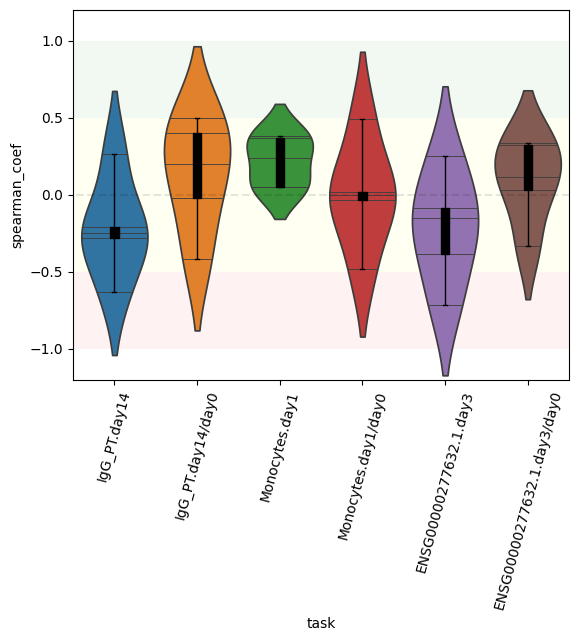

In [18]:
fig, ax = plt.subplots()

# add boundary areas
alpha = 0.05
ax.add_patch(Rectangle((-1, -1), 7, 0.5, facecolor='red', alpha=alpha))
ax.add_patch(Rectangle((-1, -0.5), 7, 1, facecolor='yellow', alpha=alpha))
ax.add_patch(Rectangle((-1, 0.5), 7, 0.5, facecolor='green', alpha=alpha))

# add lines
alpha = 0.1
ls = 'dashed'
ax.hlines(y=0, xmin=-1, xmax=6, color='black', alpha=alpha, linestyles=ls)
ax.set_ylim(-1.2, 1.2)

# add main plots
sns.violinplot(x='task', y='spearman_coef', hue='task', data=results_df, inner='stick', cut=1.75, ax=ax)
sns.boxplot(x='task', y='spearman_coef', color='black', data=results_df, width=0.1, saturation=0.1, whis=20, ax=ax)

# rotate xticks
ax.tick_params(axis='x', labelrotation=75)

fig_fn = os.path.join(outdir, 'fivefold-cross-validation.violinplot.{}.png'.format(cmodel))
fig.savefig(fig_fn, bbox_inches='tight', dpi=600)